In [1]:
import glob
import random
import math
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime
import time
import os

import pprint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

Check if GPUs are available

In [2]:
print("GPUs: ", tf.config.list_physical_devices('GPU'))

GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Find data files recursively from root folder.

In [3]:
data_path = "D:/Coding/Thesis/Data/STFT Output/**/*.h5"
data_files = glob.glob(data_path, recursive=True)

In [4]:
config = {}

config['model_folder'] = 'D:/Coding/Thesis/movement_prediction/Models/'

config['EEG_window_length_in_ms'] = 30000

Next, we configure the output layer of the LSTM:


`delta_time_k` predicts the delta time to the next $k^{th}$ tap.

`tap_count_times_p` predicts the *number of taps* within the next $p$ seconds.

In [5]:
config['delta_time_k'] = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
config['tap_count_times_p'] = np.array([0.5, 1, 5, 10, 50, 100, 500])

config['n_output_features'] = np.sum([config['delta_time_k'].shape, config['tap_count_times_p'].shape])

config['read_config_from_h5'] = True

config['EEG_sampling_rate'] = 1000
config['stft_stride'] = 128
config['sampling_rate_after_stft'] = config['EEG_sampling_rate'] / config['stft_stride']
config['sample_length_after_stft'] = 1000 / config['sampling_rate_after_stft']

config['tap_count_times_in_samples'] = np.multiply(config['tap_count_times_p'], config['EEG_sampling_rate'])

# Load data into memory

Instead of loading data from the h5 file when we need it, we load all the data of a single participant into memory (because it fits and it's easier)

In [6]:
def load_data(h5_files):
    EEG, taps = [], []
    
    # Makes sure that if a single file is passed in, it is put into a list
    if type(h5_files) != 'list':
        h5_files = [h5_files]
    
    for f in h5_files:
        with h5py.File(f, 'r') as f_open:
            if config['read_config_from_h5']:
                    config['EEG_sampling_rate'] = f_open.attrs['original_sampling_rate']
                    config['stft_stride'] = f_open.attrs['stft_hopsize']
            
            for session in list(f_open.keys()):
                for activity_window in list(f_open[session].keys()):
                    if activity_window.startswith('window_'):
                        EEG.append(np.array(f_open[session][activity_window]['stft'], dtype='float32'))
                        taps.append(np.array(f_open[session][activity_window]['taps']))
    
    ############# Inf found in data!
    for i in EEG:
        i[np.isinf(i)] = 0
    
    return (EEG, taps)

stft, taps = load_data('D:\\Coding\\Thesis\\Data\\STFT Output\\DS99.h5')

config['window_length_sftf_samples'] = np.ceil(30000 / 1000 * config['EEG_sampling_rate'] / config['stft_stride']).round().astype(np.int16)[0]

print(config['window_length_sftf_samples'])
print(f'Number of activity windows: {len(stft)}')
print([x.shape for x in stft])
print([y.shape for y in taps])

235
Number of activity windows: 7
[(64, 12300, 11), (64, 17318, 11), (64, 941, 11), (64, 802, 11), (64, 649, 11), (64, 649, 11), (64, 7450, 11)]
[(1, 698), (1, 876), (1, 50), (1, 54), (1, 4), (1, 3), (1, 516)]


Remove all activity windows that are shorter than 10 * a single window length.



In [7]:
def normalize_input(_input, normalize_over_eeg_channels=False):
    '''stft: A list of numpy arrays.
    
   Normalize over all features, ignoring  
    
    '''
    stft_cat = np.concatenate(_input, axis=1)
    
    print(f'NaN: {np.sum(np.isnan(stft_cat))}')
    print(f'Inf: {np.sum(np.isinf(stft_cat))}')
    
    if normalize_over_eeg_channels:
        axes = (0, 1)
    else:
        axes = 1
    
    means = np.mean(stft_cat, axis=axes, keepdims=True)
    st_devs = np.std(stft_cat, axis=axes, keepdims=True)
    
    out = [(i - means) - st_devs for i in _input]
    
    return out
    

stft_norm = normalize_input(stft)

#print([x.shape[1] for x in stft_norm])

# Remove end of EEG activity, since there is no activity of interest

seconds_to_remove = 28
samples_to_remove = np.ceil(config['sampling_rate_after_stft'] * seconds_to_remove).astype(np.int)

stft_norm = [x[:, :-samples_to_remove, :] for x in stft_norm]

#print([x.shape[1] for x in stft_norm])



NaN: 0
Inf: 0


## The DataLoader class
The DataLoader class contains and acts on participant data. It knows about the structure of the h5 files and can return random windows of EEG activity and taps, i.e., training data.

The stft data in the h5 files is 3-dimensional:
1. EEG channel
2. EEG timeseries
3. STFT frequency bins

In [8]:
class DataLoader(keras.utils.Sequence):
    def __init__(self, x, y, window_length=30000, batch_size=32, n_samples=2000, shuffle=True):
        if not isinstance(x, list):
            x = [x]
        if not isinstance(y, list):
            y = [y]
        
        self.x = x
        self.y = y
        self.window_length = window_length
        self.batch_size = batch_size
        self.n_samples = n_samples
        self.shuffle = shuffle
        
        self.subset_probabilities = self._get_subset_probabilites(x)
        
        self.sample_IDs = self._build_sample_IDs()
        
        self.x_n = len(x)
        self.window_length_in_samples = np.ceil(self.window_length / config['stft_stride']).astype(np.int)
        self.n_input_features = np.prod([self.x[0].shape[0], self.x[0].shape[2]])
        self.n_output_features = config['n_output_features']
    
    
    def __len__(self):
        '''Number of unique samples divided by the batch size.'''
        win_lengths = [win.shape[1] for win in self.x]
        return sum(win_lengths) // self.batch_size
    
    
    def __getitem__(self, index):
        '''
        Get a single batch from a Sequence.
        '''
        
        if self.shuffle:
            tmp_batch_size = np.minimum(self.batch_size, self.sample_IDs.shape[0])
            #print(f'\nX LENGTH: {self.sample_IDs.shape[0]}')
            
            sample_idx = np.random.choice(self.sample_IDs.shape[0], size=tmp_batch_size, replace=False)
            
            subset_idx = self.sample_IDs[sample_idx, 0]
            window_end_idx  = self.sample_IDs[sample_idx, 1]
            
            self._delete_picked_sample_IDs(sample_idx)
            
            #subset_idx = np.random.choice(len(self.x), size=self.batch_size, p=self.subset_probabilities)
            #window_end_idx = np.zeros(len(subset_idx))
            
            #for i, subset_i in enumerate(subset_idx):
            #    # Pick random EEG windows
            #    window_end_idx[i] = np.random.randint(0, high=self.x[subset_i].shape[1])
                
            X = np.zeros([self.batch_size, config['window_length_sftf_samples'], self.n_input_features])
            Y = np.zeros([self.batch_size, self.n_output_features])
        else:
            subset_idx = np.repeat(index, self.x[index].shape[1])
            window_end_idx = range(self.x[index].shape[1])
            
            X = np.zeros([self.x[index].shape[1], config['window_length_sftf_samples'], self.n_input_features], dtype=np.float32)
            Y = np.zeros([self.x[index].shape[1], self.n_output_features], dtype=np.int)
            
        
        for i, window_idx in enumerate(window_end_idx):
            
            window_length_in_samples = np.ceil(self.window_length / config['stft_stride']).astype(np.int)

            #window_end_idx = np.random.randint(0, self.x[subset_idx].shape[1])     
            window_start = np.maximum(window_idx - self.window_length_in_samples, 0)
            window_idx_stft = np.arange(window_start, window_idx, dtype=np.int)  

            input_data = np.array(self.x[subset_idx[i]][:, window_idx_stft, :])

            # Pad input data to the left, to ensure equal input data size
            n_pad_before = np.maximum(0, config['window_length_sftf_samples'] - input_data.shape[1])
            pad_width = ((0, 0), (n_pad_before, 0), (0, 0))
            input_data = np.pad(input_data, pad_width, mode='constant', constant_values=0)

            # Move Time information to first axis
            #input_data = np.moveaxis(input_data, 1, 0) # (T, 64, F)
            input_data = np.transpose(input_data, (1, 0, 2))

            # Reshape multidimensional features into a single dimension
            input_data = np.reshape(input_data, (input_data.shape[0], -1)) # (T, (64*F))


            # Get appropriate tap info        
            window_end_idx_tap_adjusted = np.array(window_idx) * config['sampling_rate_after_stft']

            output_data = self.get_taps_in_window(self.y[subset_idx[i]], window_idx)

            X[i, :, :] = input_data
            Y[i, :] = output_data
                
        return X.astype(np.float32), Y
    
    
    
    def on_epoch_end(self):
        # Reset available sample IDs at end of epoch
        self.sample_IDs = self._build_sample_IDs()
    
    def _get_subset_probabilites(self, x):
        lengths = np.array([win.shape[1] for win in x])
        
        return lengths / sum(lengths)
    
    def _build_sample_IDs(self):
        sample_IDs = np.empty([0, 2], dtype=np.int)
        sample_IDs = []
        
        for subset_i, subset in enumerate(self.x):
            subset_size = subset.shape[1]
            
            sample_IDs.append(np.array([np.repeat(subset_i, subset_size),
                                        np.arange(subset_size, dtype=np.int)]))
                              
        return np.concatenate(sample_IDs, axis=1).T
    
    def _delete_picked_sample_IDs(self, idx):
        self.sample_IDs = np.delete(self.sample_IDs, idx, axis=0)
    
    def get_taps_in_window(self, taps, window_end):      
        tap_deltas = self.get_delta_taps(taps, window_end)
        
        future_tap_n = self.get_n_future_taps(taps, window_end)
        
        result = np.concatenate((tap_deltas, future_tap_n))

        # Convert values to log to compress values
        result = [np.log10(tap) if tap > 0 else tap for tap in result]
        
        threshold_ms = 1
        result = np.maximum(result, np.log10(threshold_ms))
        
        return result
    
    
    def get_delta_taps(self, taps, window_idx):
        n_k = len(config['delta_time_k'])
        
        next_kth_taps = taps[taps > window_idx][:n_k]
        
        # Ensure that if not enough taps were found the array is padded with 0s.
        # This only occurs 
        if len(next_kth_taps) < n_k:
            next_kth_taps = np.concatenate((next_kth_taps, np.zeros(n_k - len(next_kth_taps))))
        
        tap_deltas = next_kth_taps - window_idx
        
        return tap_deltas * config['stft_stride']
            
    
    def get_n_future_taps(self, taps, window_idx):
        
        n_future_taps = np.zeros(len(config['tap_count_times_in_samples']))
        
        for p_idx, p in enumerate(config['tap_count_times_in_samples']):
            n_future_taps[p_idx] = len(
                taps[
                    (taps > window_idx) &
                    (taps <= (window_idx + p))
                ]
            )
        
        return n_future_taps

# Determining the in- and outputs of the LSTM
Next, we check the sizes that are returned by our data generation function.

## Generate train, validation, and test set

In [9]:
stft_norm_train = []
stft_norm_validation = []
stft_norm_test = []

taps_train, taps_validation, taps_test = [], [], []

for i, x in enumerate(stft_norm):
    x_len = x.shape[1]
    
    # Check if activity window length is too short.
    # If so, add it to train set.
    # If extremely short, discard window
    if taps[i].shape[1] < 5:
        continue
    
    train_idx = np.arange(0, (x_len//10 * 8))

    
    validation_idx = np.arange((x_len//10 * 8), (x_len//10 * 9))
    test_idx = np.arange((x_len//10 * 9), x_len)
    
    stft_norm_train.append(x[:, train_idx, :])
    stft_norm_validation.append(x[:, validation_idx, :])
    stft_norm_test.append(x[:, test_idx, :])
    
    # Add taps
    _taps = taps[i] / config['stft_stride']
    
    #print(f"Last train idx: {train_idx[-1]}")
    #print(f"Last train idx * sampling rate redux: {train_idx[-1] * config['sampling_rate_after_stft']}")
    #print(f"Taps: {_taps}")

    
    _taps_train = _taps[np.logical_and(_taps > (train_idx[0]), \
                                       _taps < (train_idx[-1]))]
    
    _taps_vali = _taps[np.logical_and(_taps > (validation_idx[0]), \
                                      _taps < (validation_idx[-1]))]
    
    _taps_test = _taps[np.logical_and(_taps > (test_idx[0]), \
                                      _taps < (test_idx[-1]))]
    
    # Adjust tap timings to zero at beginning of sequence
    _taps_train = _taps_train - (train_idx[0])
    _taps_vali = _taps_vali - (validation_idx[0])
    _taps_test = _taps_test - (test_idx[0])
    
    taps_train.append(_taps_train)
    taps_validation.append(_taps_vali)
    taps_test.append(_taps_test)
    
print(f'Total taps: {[y.shape for y in taps]}')

print([y.shape for y in taps_train])
print([y.shape for y in taps_validation])
print([y.shape for y in taps_test])


#print(stft_norm[0].shape)
#print(taps[0][0, -1] / 128)


Total taps: [(1, 698), (1, 876), (1, 50), (1, 54), (1, 4), (1, 3), (1, 516)]
[(545,), (656,), (48,), (35,), (373,)]
[(63,), (111,), (0,), (5,), (68,)]
[(90,), (109,), (2,), (14,), (75,)]


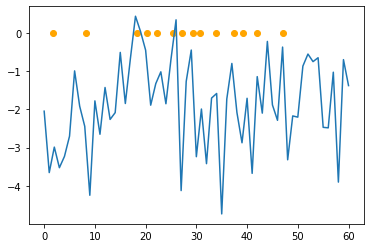

In [10]:
plt.plot(stft_norm_test[3][0, :, 0])
plt.scatter(taps_test[3], np.zeros(taps_test[3].shape), color='orange')
plt.show()

## Create DataGenerators for train, validation, and test

In [11]:
ppt_train = DataLoader(stft_norm_test, taps_test, shuffle=False)

my_batch_x, my_batch_y = ppt_train[0]

And do a sanity check on the content of the generated target data.

Input layer dimensions: (1209, 235, 704)
Output layer dimensions: (1209, 17)


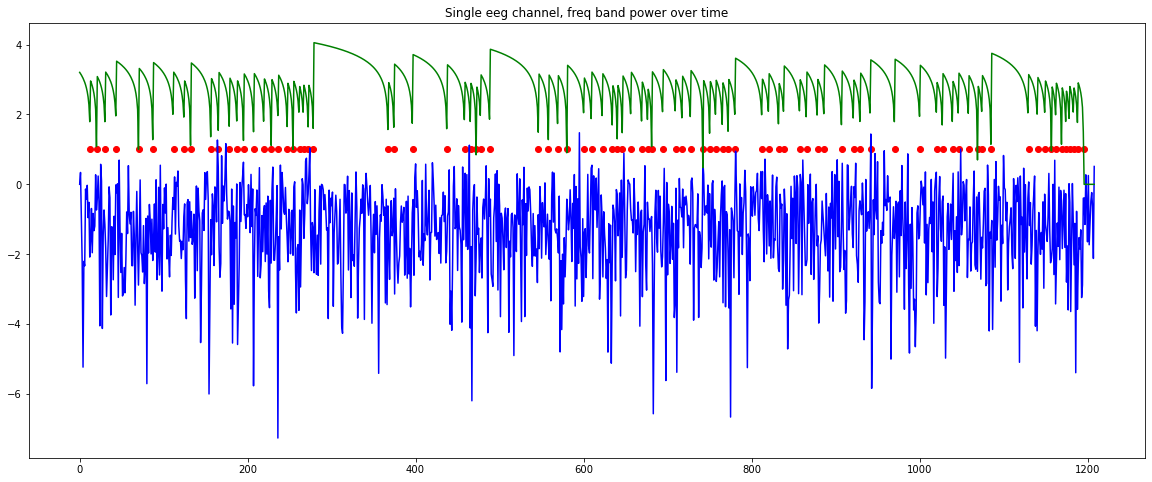

In [12]:
np.set_printoptions(suppress=True)

print(f'Input layer dimensions: {my_batch_x.shape}')
print(f'Output layer dimensions: {my_batch_y.shape}')
#print(f'Output layer values: {my_batch_y[0]}')

plt.figure(figsize=(20, 8))
plt.plot(my_batch_x[:, -1, 8], color='blue')
plt.plot(my_batch_y[:, 0], color='green')
plt.scatter(ppt_train.y[0], np.ones(ppt_train.y[0].shape), color='red')
plt.title('Single eeg channel, freq band power over time')
plt.show()

In [13]:
ppt_train = None
my_batch_x = None
my_batch_y = None

## Input layer
The ParticipantData class generates an input information that is $938 \times 64 \times 32$ in size. Since the first dimension is the temporal information, the LSTM's input layer has a size of $64 \times 32 = 2048$ and takes a window of 938 samples at a time.

This conversion from window length in ms to window length in STFT samples can be calculated by the following formula:

$$
\bigl\lceil
\frac{\frac{\text{T}}{1000} \text{Fs}}
{\text{R}}
\bigr\rceil
$$

, where $T$ is the window length in ms, $Fs$ is the original sampling rate, and $R$ is the hopsize of the STFT.

## Output layer
The ParticipantData class also generates training output. The output layer has a length of 17. It is composed of the $\Delta t$ to the next $k$ steps in ms, as well as the number of taps within the next $p$ seconds. Which and how many $k$ and $p$ are predicted is defined in the config dictionary at the top of the script. The size of the output layer is defined as $|K| + |P|$

# LSTM
## Configure LSTM

In [14]:
model_file = ''

load_latest = False

if load_latest:
    files = [os.path.join(config['model_folder'], f) for f in os.listdir(config['model_folder']) if (f.lower().endswith('.h5'))]
    file_mtimes = [os.path.getmtime(f) for f in files]
    
    files.sort(key=os.path.getmtime, reverse=True)
    
    model_file = files[0]
if model_file != '':
    model = keras.models.load_model(model_file)
    model.summary()

In [21]:
LSTM_config = {
    'input_layer_size': np.prod([stft[0].shape[0], stft[0].shape[2]]),
    'output_layer_size': np.hstack([config['delta_time_k'], config['tap_count_times_p']]).shape[0]
}

print(LSTM_config)

model = None
model = keras.Sequential()

model.add(keras.Input(shape=(None, LSTM_config['input_layer_size'])))
model.add(layers.Conv1D(filters=256,
                        kernel_size=3,
                        kernel_regularizer=keras.regularizers.L2(1e-3),
                        bias_regularizer=keras.regularizers.L2(1e-3),
                        padding='same',
                        name='Conv_1D_1'))
model.add(layers.LSTM(units=512,
                      kernel_regularizer=keras.regularizers.L2(1e-3),
                      bias_regularizer=keras.regularizers.L2(1e-3),
                      name='LSTM_1'))
model.add(layers.Dense(1024, activation='relu', name='dense_1'))
model.add(layers.Dropout(0.1, name='dropout_1'))
model.add(layers.Dense(1024, activation='relu', name='dense_2'))
model.add(layers.Dropout(0.1, name='dropout_2'))
model.add(layers.Dense(LSTM_config['output_layer_size'], name='output_layer'))

model.summary()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=300,
    decay_rate=0.7)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='mean_squared_error', optimizer=opt)

{'input_layer_size': 704, 'output_layer_size': 17}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1D_1 (Conv1D)           (None, None, 256)         540928    
_________________________________________________________________
LSTM_1 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
out

### Fit model

In [22]:
ppt_train = DataLoader(stft_norm_train, taps_train, batch_size=1)

ppt_validation = DataLoader(stft_norm_validation, taps_validation, batch_size=1)

ppt_test = DataLoader(stft_norm_test, taps_test, shuffle=False)

print(f'Train set contains {len(ppt_train)} batches with batch size of {ppt_train.batch_size}. Total number of samples: {len(ppt_train) * ppt_train.batch_size}')
print(f'Validation set contains {len(ppt_validation)} batches with batch size of {ppt_validation.batch_size}. Total number of samples: {len(ppt_validation) * ppt_validation.batch_size}')
print(f'Test set contains {len(ppt_test) * ppt_test.batch_size} samples')

Train set contains 30160 batches with batch size of 1. Total number of samples: 30160
Validation set contains 3770 batches with batch size of 1. Total number of samples: 3770
Test set contains 3776 samples


In [23]:
model.fit(ppt_train,
          epochs=2,
          validation_data=ppt_validation,
          use_multiprocessing=False,
          verbose=2)

Epoch 1/2
30160/30160 - 1487s - loss: 1.0233 - val_loss: 1.7238
Epoch 2/2
30160/30160 - 1367s - loss: 0.9930 - val_loss: 1.7215


In [24]:
time_now = datetime.now().strftime('%d.%m.%Y_%H.%M.%S')

save_location = config['model_folder'] + 'mov_pred_model_' + time_now + '.h5'

print(f'Saving model at {save_location}')
model.save(save_location)
print(f'Model done saving.')

Saving model at D:/Coding/Thesis/movement_prediction/Models/mov_pred_model_19.03.2021_11.10.32.h5
Model done saving.


## Plot model prediction against true values

In [25]:
# Predict on all sequences
#ppt_validation_shuffle = DataLoader(stft_norm_validation, taps_validation, batch_size=64, shuffle=True)
#ppt_train_unshuffled = DataLoader(stft_norm_test, taps_test, shuffle=False)

_X, _Y, _Y_hat = [], [], []
for i in range(ppt_test.x_n):
    _x, _y = ppt_test[i]
    _X.append(_x)
    _Y.append(_y)
    _Y_hat.append(model.predict(_x))

In [62]:
_Y_random = model.predict(np.random.rand(_x.shape[0], _x.shape[1], _x.shape[2]))

In [68]:
_Y_hat_train = model.predict(ppt_train[0][0])

<Figure size 432x288 with 0 Axes>

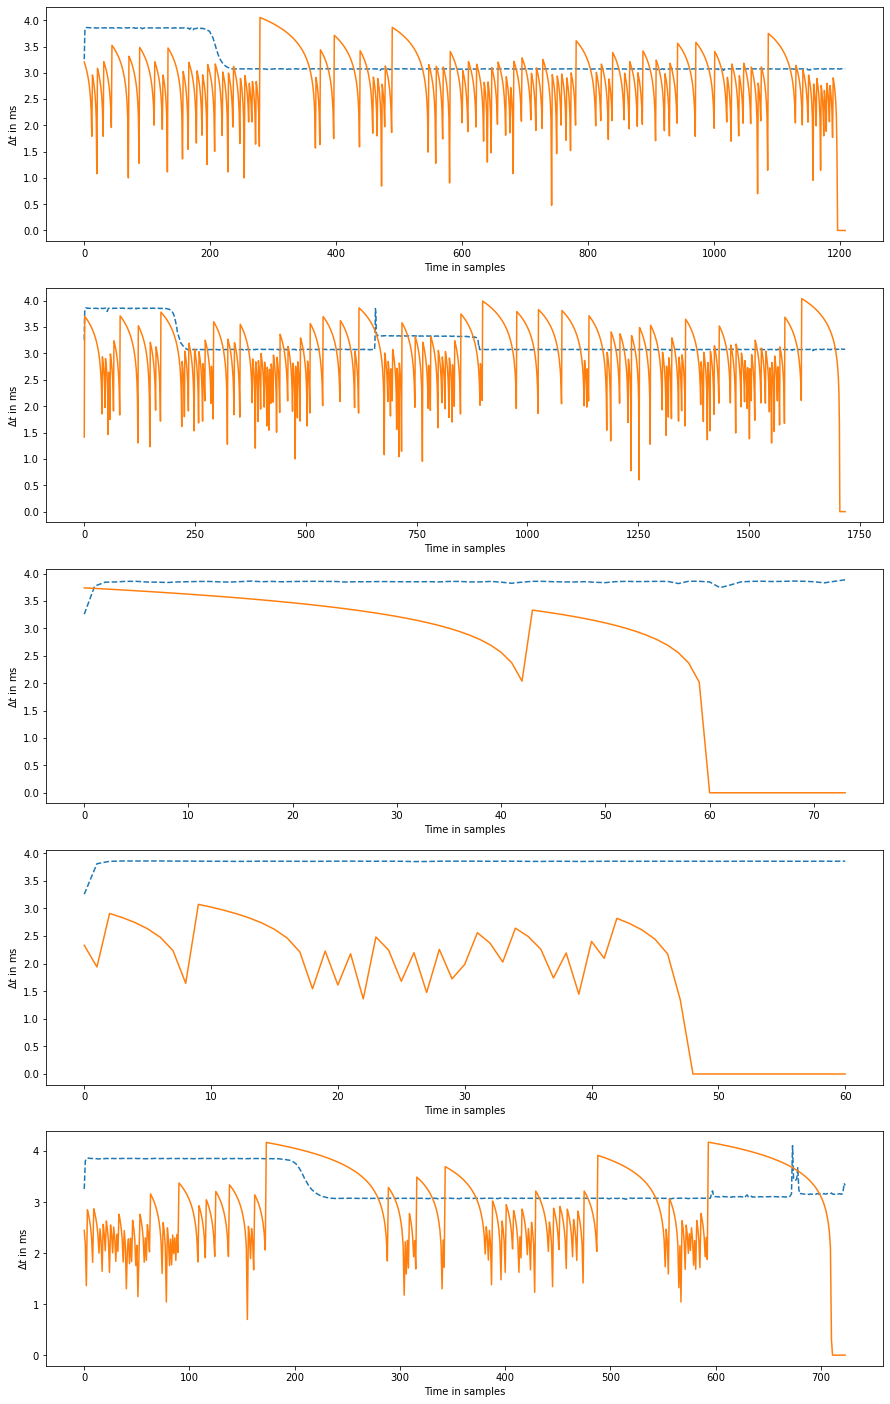

In [26]:
# New plots for new test framework
%matplotlib inline

#RMSE = np.sqrt(((_Y_hat[0] - _Y[0]) ** 2).mean(0))

sequence_id = 0
output_feature = 0

#fig, ((deltas_plt, n_taps_plt), (RMSE_deltas_plt, RMSE_ntaps_plt)) = plt.subplots(2, 2, figsize=(15, 15))

plt.figure()
fig, axs = plt.subplots(len(_Y), 1, figsize=(15, 5 * len(_Y)))


for sequence_id in range(len(_Y)):
    axs[sequence_id].plot(_Y_hat[sequence_id][:, output_feature], '--')
    axs[sequence_id].plot(_Y[sequence_id][:, output_feature], '-')
    #axs[sequence_id].plot(_Y_random[:, output_feature], '-')
    axs[sequence_id].set_xlabel('Time in samples')
    axs[sequence_id].set_ylabel('$\Delta t$ in ms')

plt.show()

C:\Users\lukav\Anaconda3\envs\movement_prediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

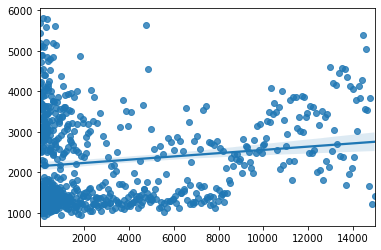

In [123]:
# XY Scatter plot
import seaborn as sb


sb.regplot(10 ** _Y[sequence_id][:, output_feature],
           10 ** _Y_hat[sequence_id][:, output_feature])

#plt.figure(figsize=(11, 11))
#plt.scatter(10 ** _Y[sequence_id][:800, output_feature],
#            10 ** _Y_hat[sequence_id][:800, output_feature])

#plt.show

## Comparing predicted versus observed values statistically

In order to compare the observed versus predicted delta times, we can try to predict predicted values from the real values sing a polynomial linear regression.

Here, I construct a simple polynomial regression model to predict predicted values from observed values.

TODO: Model that predicts residuals from observed values.

In [ ]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

reg = PolynomialFeatures(degree=2)

reg.fit_transform(_Y[0][:800, output_feature].reshape(-1, 1),
                  _Y_hat[0][:800, output_feature].reshape(-1, 1))

print(reg)

In [ ]:
%matplotlib inline

batch_id = np.arange(8)

RMSE = np.sqrt(((y_hat - _y) ** 2).mean(0))

fig, ((deltas_plt, n_taps_plt), (RMSE_deltas_plt, RMSE_ntaps_plt)) = plt.subplots(2, 2, figsize=(15, 15))

# Generate rainbow colors
colors = mpl.cm.rainbow


# Mean plots
deltas_plt.plot(10 ** y_hat[batch_id, 0:10].T, '--')
#deltas_plt.fill_between(np.arange(len(config['delta_time_k'])),
#                        10 ** np.min(y_hat[:, 0:10], axis=0),
#                        10 ** np.max(y_hat[:, 0:10], axis=0))

deltas_plt.plot(10 ** _y[batch_id, 0:10].T)
deltas_plt.set(title='Delta time to future taps in ms',
               xlabel='kth future tap',
               ylabel='$\Delta t$ in ms')
plt.sca(deltas_plt)
plt.xticks(np.arange(len(config['delta_time_k'])), config['delta_time_k'])

n_taps_plt.plot(10 ** y_hat[batch_id, 10:].T, '--')
n_taps_plt.plot(10 ** _y[batch_id, 10:].T)
n_taps_plt.set(title='Number of taps in future p seconds',
               xlabel='Future time in s',
               ylabel='n taps')
plt.sca(n_taps_plt)
plt.xticks(np.arange(len(config['tap_count_times_p'])), config['tap_count_times_p'])

custom_legend_items = [mpl.lines.Line2D([0], [0], lw=2, ls='--'),
                       mpl.lines.Line2D([0], [0], lw=2, ls='-')]
plt.legend(custom_legend_items, [r'$\hat{Y}$', r'$Y$'], bbox_to_anchor=(1.2, 1), loc=1)



# RMSE plots
RMSE_deltas_plt.plot(RMSE[:10])
RMSE_deltas_plt.set(title='RMSE delta time',
               xlabel='kth future tap',
               ylabel='RMSE')
plt.sca(RMSE_deltas_plt)
plt.xticks(np.arange(len(config['delta_time_k'])), config['delta_time_k'])

RMSE_ntaps_plt.plot(RMSE[10:])
RMSE_ntaps_plt.set(title='RMSE n future taps',
               xlabel='Future time in s',
               ylabel='RMSE')
plt.sca(RMSE_ntaps_plt)
plt.xticks(np.arange(len(config['tap_count_times_p'])), config['tap_count_times_p'])



plt.show()

# Linear Model

Since the Neural Network model was not working well at all, let's try to fit a simple linear model with L1 regularization, instead. Using LASSO regression allows us to perform dimensionality reduction at the same time.

In [10]:
ppt_train_lm = DataLoader(stft_norm_train, taps_train, shuffle=False)

#ppt_validation_lm = DataLoader(stft_norm_validation, taps_validation, batch_size=1)

#ppt_test_lm = DataLoader(stft_norm_test, taps_test, shuffle=False)


In [12]:
mini_x, mini_y = ppt_train_lm[0]
print(len(mini_x))

MemoryError: Unable to allocate 5.96 GiB for an array with shape (9664, 235, 704) and data type float32

In [ ]:
ppt_train_lm_matrix_X = np.zeros([len(ppt_train_lm), ])
ppt_train_lm_matrix_Y = np.zeros()

for sample in range(len(ppt_train_lm)):
    pass